# Readme


# Dataset used :

Flickr30k Dataset : https://drive.google.com/file/d/1FNVlyMc4xRePZZMuCm1fFCDJZAyXr1CL/view?usp=sharing

Google-news-vectors-negative-300 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?usp=sharing&resourcekey=0-wjGZdNAUop6WykTtMip30g

# Library Used :

Tensorflow

# Training:

Trained for 20 epochs, 1500 batch size in each epoch

# Changes Done:

Changed the feature extractor from InceptionV3 to Xception

Changed the orignal LSTM, to one where the cell state is set to 0 after every pass through


# Bleu scores

0.2890064862060426 - Xception - Original LSTM - Decoder 2

0.2621547947179256 - Xception - Changed LSTM - Decoder 3

0.28369470634644833 - InceptionV3 - Original LSTM - Decoder 5


# Important Links

Google drive link for our saved data : https://drive.google.com/drive/folders/1nqEDl1WHxc_02RvnhYl5kcyU8Y3SLWW9?usp=drive_link

Google Colab Link for our code : https://colab.research.google.com/drive/1L65WBAqzTFwX22OCEW4C8fYRkbEv9n1s?usp=sharing

A very recent paper to demonstrate what BLEU scores look like : https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00571-w

The paper our work is based on : https://arxiv.org/pdf/1502.03044

The code repository that we are using for our code : https://github.com/vinayaksharmagh/IMcap/tree/master



# EXTRACT STARTS HERE

In [ ]:
import tarfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with tarfile.open('/content/drive/MyDrive/flickr30k-images.tar.gz', 'r') as f:
  f.extractall('/content/ImageCap/imagesB/')

In [ ]:
import os, os.path

path = '/content/ImageCap/imagesB/flickr30k-images/Images/'


#Ensuring that all the 31784 images have been successfuly extracted (such sanity checks are neccesary
#when working on colab-gdrive duo)
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
num_files

31784

# Image features


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import random

In [ ]:
image_path = '/content/ImageCap/imagesB/flickr30k-images/Images/'
feat_path = '/content/ImageCap/image_feat_Xception/'
text_path = '/content/results.csv'

In [ ]:
df = pd.read_csv(text_path,delimiter='|', skipinitialspace=True) #in this csv, | is being used as delimiter

In [ ]:
df.head()

image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young , White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

In [ ]:
image_name_list = list(set(df['image_name'])) #obtaining unique instance name of each image
image_path_list = list(map(lambda arg: image_path + arg, image_name_list))
feat_path_list = list(map(lambda arg: feat_path + arg, image_name_list))
#Its imp to keep images and features in different directories so as to avoid Colab's infamous I/O error

In [ ]:
print(feat_path_list)

['/content/ImageCap/image_feat_Xception/1333888922.jpg', '/content/ImageCap/image_feat_Xception/2525898604.jpg', '/content/ImageCap/image_feat_Xception/121590361.jpg', '/content/ImageCap/image_feat_Xception/3446892469.jpg', '/content/ImageCap/image_feat_Xception/3039095384.jpg', '/content/ImageCap/image_feat_Xception/4447270536.jpg', '/content/ImageCap/image_feat_Xception/6066636675.jpg', '/content/ImageCap/image_feat_Xception/7507256476.jpg', '/content/ImageCap/image_feat_Xception/541342477.jpg', '/content/ImageCap/image_feat_Xception/3407357681.jpg', '/content/ImageCap/image_feat_Xception/3866425459.jpg', '/content/ImageCap/image_feat_Xception/4516012575.jpg', '/content/ImageCap/image_feat_Xception/4013421575.jpg', '/content/ImageCap/image_feat_Xception/2922793524.jpg', '/content/ImageCap/image_feat_Xception/1149286224.jpg', '/content/ImageCap/image_feat_Xception/4224693415.jpg', '/content/ImageCap/image_feat_Xception/153299765.jpg', '/content/ImageCap/image_feat_Xception/166433861.j

In [ ]:
def feat_extract():#Here we are performing surgery on a pretrained Inception V3 model so as to just obtain a model upto last conv layer

  IV3 = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet') #creating an inceptionV3 instance without last classification layer

  x_in = IV3.input #we will feed input to the input layer of inception V3
  x_out= IV3.layers[-1].output #output of the last conv layer in inception V3 will will be taken as output

  return tf.keras.Model(inputs=x_in, outputs=x_out) #Output will be of dimention 8*8*2048

mod_fe = feat_extract()


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
mod_fe.save('/content/ImageCap/IV3_feat.h5') #saving because, we will also need it during evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# different feature extractor for testing, this one is Xception
def feat_extract():#Here we are performing surgery on a pretrained Xception model so as to just obtain a model upto last conv layer

  XV = tf.keras.applications.Xception(include_top=False,weights='imagenet') #creating an Xception instance without last classification layer

  x_in = XV.input #we will feed input to the input layer of Xception
  x_out= XV.layers[-1].output #output of the last conv layer in Xception will will be taken as output

  return tf.keras.Model(inputs=x_in, outputs=x_out) #Output will be of dimention 8*8*2048

mod_fe = feat_extract()

In [ ]:
mod_fe.save('/content/ImageCap/XV_feat.h5') #saving because, we will also need it during evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def load_image(arg):#for inceptionV3
    img = tf.io.read_file(arg)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # inception and xception take 299x299 as input size whereas teh default input size of resnet 50 is 224*224
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, arg

In [ ]:
def load_image(arg):#for xception
    img = tf.io.read_file(arg)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # inception and xception take 299x299 as input size whereas teh default input size of resnet 50 is 224*224
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, arg

In [ ]:
#Features are being extracted seperately so as to avoid this part from becoming a bottleneck in further training
#Apart from this, features are cached in hard disk instead of RAM because of RAM's limitation in Collab
image_dataset = tf.data.Dataset.from_tensor_slices(image_path_list)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) #this is a map() extention for "Dataset" type stucture
image_dataset = image_dataset.batch(32) #Since Inception V3 expects batch input anyways, so to leverage possible vectorization its better to send input in batches

# print(image_dataset)
for img, path in image_dataset:
  batch_features = mod_fe(img)
  # print(batch_features.shape)

  batch_features = tf.reshape(batch_features,(batch_features.shape[0], 10*10, batch_features.shape[3]))
  # batch_features = tf.reshape(batch_features,(batch_features.shape[0], 8*8, batch_features.shape[3]))
  # print(batch_features.shape)
  # print(batch_features.shape)
  # break 32 64 1038
  for bf, p in zip(batch_features, path):
    path_ = p.numpy().decode("utf-8") #p is needed to be decoded as string becuase it is originally obtained as numpy object
    path_ = feat_path + path_[len(image_path):] # path_[len(image_path):] extracts name of image which is then concatenated to feature path
    # print(path_)
    np.save(path_, bf.numpy()) #saves feature matrix with same name as that of image
    #Feature matrix is of dim 64x2048 for inception and 100x2048 for Xception

In [ ]:
#verifying quantity
import os, os.path
path = '/content/ImageCap/image_feat_Xception/'
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

num_files

31783

In [ ]:
!tar -cvzf dataset.tar.gz "/content/ImageCap/image_feat_Xception"

Streaming output truncated to the last 5000 lines.
/content/ImageCap/image_feat_Xception/2633093295.jpg.npy
/content/ImageCap/image_feat_Xception/2244594614.jpg.npy
/content/ImageCap/image_feat_Xception/7034076961.jpg.npy
/content/ImageCap/image_feat_Xception/3408565899.jpg.npy
/content/ImageCap/image_feat_Xception/610825957.jpg.npy
/content/ImageCap/image_feat_Xception/7703165508.jpg.npy
/content/ImageCap/image_feat_Xception/4450821292.jpg.npy
/content/ImageCap/image_feat_Xception/3068407619.jpg.npy
/content/ImageCap/image_feat_Xception/3716283232.jpg.npy
/content/ImageCap/image_feat_Xception/2253091968.jpg.npy
/content/ImageCap/image_feat_Xception/2975073156.jpg.npy
/content/ImageCap/image_feat_Xception/2373790865.jpg.npy
/content/ImageCap/image_feat_Xception/2657643451.jpg.npy
/content/ImageCap/image_feat_Xception/2542355262.jpg.npy
/content/ImageCap/image_feat_Xception/358012011.jpg.npy
/content/ImageCap/image_feat_Xception/4591476340.jpg.npy
/content/ImageCap/image_feat_Xception/7

In [ ]:
from google.colab import files
files.download('/content/ImageCap/image_feat_Xception')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
shutil.rmtree('/content/ImageCap/imagesB')


# Text processing


In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import json
from nltk import RegexpTokenizer
import time
from keras.preprocessing.text import Tokenizer
import random
import multiprocessing
from nltk import RegexpTokenizer
import copy
import pickle
multiprocessing.cpu_count()

8

In [ ]:
!pip show keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [ ]:
image_path = '/content/ImageCap/imagesB/flickr30k-images/Images/'
text_path = '/content/results.csv'

In [ ]:
df = pd.read_csv(text_path ,delimiter='|', skipinitialspace=True) #in this csv, | is being used as delimiter

In [ ]:
groups = [b for a,b in df.groupby('image_name')] #Seperating rows into groups as per image name
random.shuffle(groups) #applying shuffle operation group-wise
df = pd.concat(groups).reset_index(drop=True)

In [ ]:
image_name_list = list(set(df['image_name'])) #obtaining unique instance name of each image
image_path_list = list(map(lambda arg: image_path + arg, image_name_list))

In [ ]:
df.loc[0]

image_name                                           6090223025.jpg
comment_number                                                    0
comment           A cowboy is participating in the bull riding c...
Name: 0, dtype: object

In [ ]:
df['comment'] = df['comment'].apply(lambda arg: '<start> ' + str(arg) + ' <end>') #putting start and end tokens

In [ ]:
df.loc[0]['comment']

'<start> A cowboy is participating in the bull riding competition at a rodeo , with the two other people in the rodeo area with him , and three spectators . <end>'

In [ ]:
tokenizer = RegexpTokenizer(r'\w+|<start>|<end>') #tokenizing using only alphanumeric tokens and start, end tokens
df['tokens'] = df['comment'].apply(tokenizer.tokenize)

In [ ]:
df.loc[0]['tokens']

['<start>',
 'A',
 'cowboy',
 'is',
 'participating',
 'in',
 'the',
 'bull',
 'riding',
 'competition',
 'at',
 'a',
 'rodeo',
 'with',
 'the',
 'two',
 'other',
 'people',
 'in',
 'the',
 'rodeo',
 'area',
 'with',
 'him',
 'and',
 'three',
 'spectators',
 '<end>']

In [ ]:
#Finding max length for padding
len_ = df['tokens'].apply(lambda arg: len(arg))
max_len = max(len_)

In [ ]:
#padding to max_len
def pad(arg):
  len_ = len(arg)
  len_ = max_len - len_
  lst = copy.deepcopy(arg)
  for i in np.arange(0,len_):
    lst.append('_')
  return lst

df['tokens_pad'] = df['tokens'].apply(pad)

In [ ]:
df.loc[0]['tokens_pad']

['<start>',
 'A',
 'cowboy',
 'is',
 'participating',
 'in',
 'the',
 'bull',
 'riding',
 'competition',
 'at',
 'a',
 'rodeo',
 'with',
 'the',
 'two',
 'other',
 'people',
 'in',
 'the',
 'rodeo',
 'area',
 'with',
 'him',
 'and',
 'three',
 'spectators',
 '<end>',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_']

In [ ]:
#Training our custom word2vec model (its imp to do this because google's w2v lacks stopwords and <start>, <end> tokens)
t=time.time()
obj_w2v=Word2Vec(sentences=df['tokens'],min_count=1,window=2,vector_size=300,sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20,workers=2,epochs=30)
print(time.time()-t)

72.63836407661438


In [ ]:
#Loading Google's pretrainind w2v model
t=time.time()
word2vec_path = "/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz"
w2v_g = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
print(time.time()-t)

50.71228051185608


In [ ]:
#updating our local model's vocab with google's w2v's vocab
t=time.time()
# obj_w2v.build_vocab([list(w2v_g.vocab.keys())],update=True)
obj_w2v.build_vocab([list(w2v_g.key_to_index.keys())], update=True)
print(time.time()-t)

59.84099578857422


In [ ]:
from gensim.models import KeyedVectors

# t=time.time()
model = obj_w2v.wv

# Ensure vectors_lockf is properly initialized to match the size of vectors
if not hasattr(model, 'vectors_lockf') or len(model.vectors_lockf) != len(model.vectors):
    model.vectors_lockf = np.ones(len(model.vectors), dtype=np.float32)

# Load Google News vectors
google_news_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

# Manually intersect with your model
t = time.time()
overlap_count = 0
for word in google_news_vectors.index_to_key:
    if word in model.key_to_index:
        model_index = model.key_to_index[word]
        if model_index < len(model.vectors):  # Additional check for safety
            model.vectors[model_index] = google_news_vectors[word]
            model.vectors_lockf[model_index] = 1.0  # allowing further training adjustments
            overlap_count += 1

#this function will look for words common in our vocab
#and in google's vocab and change the weight of such words to that in google's weight vector.
#Here we have set lockf=1 so that in further training weights of all the
#words are optimized

print(time.time()-t)

9.036934852600098


In [ ]:
t=time.time()
obj_w2v.train(df['tokens'],total_examples=len(df),epochs=obj_w2v.epochs)#we are training again so as to get weights adjusted
#This retraining is important so as to avoid clash of embedding space of google's w2v and our custom w2v
print(time.time()-t)

356.4481098651886


In [ ]:
obj_w2v.save('/content/ImageCap/w2v_imageCap.kv') #This will save entire model

In [ ]:
obj_w2v.wv.save_word2vec_format('/content/ImageCap/w2v_imageCap.bin', binary=True) #This will only save matrix / vocab of model

In [ ]:
import shutil
shutil.move('/content/ImageCap/w2v_imageCap.bin', '/content/drive/MyDrive/cv_project/')

Error: Destination path '/content/drive/MyDrive/cv_project/w2v_imageCap.bin' already exists

In [ ]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/ImageCap/w2v_imageCap.bin', binary=True,unicode_errors='ignore')

In [ ]:
#Now we will create a new vocab of most used tokens and then later map them to their w2v embeddings
vec=Tokenizer()
vec.fit_on_texts(df['tokens'])
l=len((vec.word_index))
#print(l)
#print((vec.word_index))#dictionary

In [ ]:
#Here we are generating a matrix that contains embedding of each word in our vocabulary
r=0
M=(np.zeros((l,300)))
#d=pd.DataFrame()
for el in vec.word_index:
  try:
    M[r,:]=word2vec[str(el)]#put entire word vector for el in rth row
  except:
    M[r,:]=np.zeros((1,300)) #in case of an unknown word, simply put zero vector
    #print('error for ',' ',el)
  #d=d.append(pd.DataFrame(data={'row':[r], 'word': [el]}))# storing the mapping of row to word
  r=r+1

#print(r)

In [ ]:
M.shape

(18289, 300)

In [ ]:
#pad token '_' has been dealt seperately because it might have affected the word2vec training if used earlier
vec.word_index['_'] = 0 #adding 0 for padding
vec.index_word[0] = '_'
M = np.vstack((np.zeros((1,300)),M)) #putting zero vector at 0th row for padding
seq = vec.texts_to_sequences(df['tokens_pad']) #converting tokens to corrosponding indicies so that they can be
                                               #they can be used for mapping by embedding layer during training
seq_vec = np.array(seq).astype('int32')

In [ ]:
df.to_csv(r'/content/ImageCap/captions_pros.csv',index=None,header=True) # all further mappings will be as per this csv
np.save('/content/ImageCap/embedB.npy',M)
np.save('/content/ImageCap/caption_vec.npy',seq_vec)

with open('/content/ImageCap/word_ind_map.pkl', 'wb') as f:
  pickle.dump(vec.word_index, f, pickle.HIGHEST_PROTOCOL)

with open('/content/ImageCap/ind_word_map.pkl', 'wb') as f:
  pickle.dump(vec.index_word, f, pickle.HIGHEST_PROTOCOL)

# Training

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt

In [ ]:
import ast
image_path = '/content/ImageCap/imagesB/flickr30k-images/Images/'
feat_path = '/content/ImageCap/image_feat_Xception/'
text_path = '/content/drive/MyDrive/cv_project/captions_pros.csv'
df = pd.read_csv(text_path)

image_name_list = list(set(df['image_name'])) #obtaining unique instance name of each image
image_path_list = list(map(lambda arg: image_path + arg, image_name_list))

<ipython-input-27-c198235bba91>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(text_path)


In [ ]:
M = np.load('/content/drive/MyDrive/cv_project/embedB.npy')
M.shape

(18290, 300)

In [ ]:
cap_seq = np.load('/content/drive/MyDrive/cv_project/caption_vec.npy')
cap_seq.shape

(158915, 80)

In [ ]:
import pickle

word_ind_map=dict()
with open('/content/drive/MyDrive/cv_project/word_ind_map.pkl', 'rb') as f:
  word_ind_map = pickle.load(f)

ind_word_map=dict()
with open('/content/drive/MyDrive/cv_project/ind_word_map.pkl', 'rb') as f:
  ind_word_map = pickle.load(f)

In [ ]:
from sklearn.utils import shuffle
#Since there are multiple captions for same images so in order to have disjoint train and test sets
#(sharing no images) we need to first split and then shuffle
#(unlike what's done by train_test_split() function of sklearn)

#num below should be a multiple of 5 because for each image there are 5 captions which means
#same image is repeated 5 times

num = 100000 #num of training examples
test_num = 10000 #num of test examples

X = np.array(df['image_name'])

X_train = X[0:num]
y_train = cap_seq[0:num]
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_test = X[num:num+test_num]
y_test = cap_seq[num:num+test_num]
X_test, y_test = shuffle(X_test, y_test, random_state=1)

print(len(X_train), len(y_train), len(X_test), len(y_test))

100000 100000 10000 10000


In [ ]:
def map_to_img(img_name, caption):
  img = np.load(feat_path + img_name.decode('utf-8') + '.npy')
  return img, caption

data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
data = data.map(lambda arg1, arg2: tf.numpy_function(func = map_to_img, inp = [arg1, arg2], Tout = [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

data = data.shuffle(1000).batch(64)
data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class ENCODER(tf.keras.Model):
  def __init__(self, embed_dim):
    super(ENCODER,self).__init__()
    self.den = tf.keras.layers.Dense(embed_dim)

  def call(self, x): #input x will be of dimention (batch x 64 x 2048), this can be visulized as 64
                     #attentionable regions in image each with 2048 features
    x = self.den(x)  #This dense is applied so as to make feature space of image regions (2048 features)
                     #and that of tokens (300 features) consistent
    x = tf.nn.relu(x)
    return x

In [ ]:
class ATTEND(tf.keras.Model): #this class deals with training of a small NN to learn score which is
                              #further used to calculate attention weights and context

  def __init__(self, units):
    super(ATTEND, self).__init__()
    #Here W1 and W2 are used to learn suitable parameters so as to obtain suitable
    #score=tanh(W1(feat)+W2(hidden)) (which minimizes cost) while V is used to apply
    #softmax on score (along dim of attentionable regions (64)) so as to obtain
    #attention weights for all attentionable regions

    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, feat, hidden): #where score depends on features computed by encoder (feat)
                                #and hidden state upto current time of decoder (hidden)
                                #where feat is of dim (batch x 64 x 300) and hidden is of
                                #dim (batch x hidden_size)

    hidden_ = tf.expand_dims(hidden, axis=1) #This basically inserts a new axis at axis
                                             #index 1 (it is being done so that addition of
                                             #W1 and W2 while calculating score can be done properly
                                             #by broadcasting axis 1 to 64 units as shown below)

    score = tf.nn.tanh( self.W1(feat) + self.W2(hidden_) ) #score will be of dim (batch x 64 x hidden_size)

    att_wt = tf.nn.softmax(self.V(score), axis=1) #Note that softmax is applied at axis=1
                                                  #(which contains all attentionable regions)
                                                  #att_wt is of dim (batch x 64 x 1)

    #Context is basically weighted sum of features (weighted by attention weights), so here
    #we first perform mult of all 300 features by att_weights (via broadcasting)
    #Then summation is done along the dimention of attentionable regions (i.e axis of 64 (here axis=1))

    context = att_wt*feat
    context = tf.reduce_sum(context, axis=1) #its dim will be (batch x hidden_size)

    return context, att_wt



In [ ]:
# original decoder
class DECODER(tf.keras.Model):

  def __init__(self, units, embed_M, sentence_length):
    super(DECODER, self).__init__()
    self.units = units
    self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], weights=[embed_M], input_length=sentence_length, trainable=False )
    self.lstm = tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True)
    # self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True))# testing bi directional LSTM

    #at each time step, lstm is supposed to return both output as well as hidden state

    #output of lstm is fed to a FC network consisting of 2 dense layers
    self.den1 = tf.keras.layers.Dense(units)
    self.den2 = tf.keras.layers.Dense(embed_M.shape[0])
    #This last dense layer contains vocab no of elements (it just contains elements and not their probability
    # (tanh activation is being used, not softmax) .Later for loss we will simply find difference
    #in probability distribution of actual and predicted elements using entropy)

    self.attend = ATTEND(units)

    #CAN TEST SET CELL STATE TO 0 AFTER EVERY PASS

  def call(self, tok, feat, hidden): #decoder takes prev time-step token, hidden state of prev
                                     #time-step decoder RNN and context vector for current time-step
                                     #(which is obtained by attedding over image feat) as input and
                                     #returns tok and hidden state at current time-step

    context, att_wt = self.attend(feat, hidden)
    x = self.embed(tok) #obtain token in embedded form (batch x 1 x embed_dim)

    #Now we need to feed both embedded tok and context as input to the lstm layer,
    #but lstm layer has single input arg, so we concatenate both these things and input this concat to lstm
    context_ = tf.expand_dims(context,1) #insert a new axis at index 1 so that upcoming concat can happen properly
    x = tf.concat([context_, x], axis=2) #concat will happen along axis=2 leading to
                                         #dim (batch x 1 x (embed_dim+hidden_size))
    output, state, _ = self.lstm(x)

    x = self.den1(output) #(batch x sentence_length x hidden_size)
    x = tf.reshape(x, (-1, x.shape[2])) # this reduces first 2 dims to single dim
                                        #by mult them to give ((batch*sentence_length) x hidden_size)
    x = self.den2(x)
    return x, state, att_wt

  def reset_state(self, batch_size): #hidden state dim is (batch x units) and is fixed for each time-step
    return tf.zeros((batch_size, self.units))


In [ ]:
# decoder where LSTM cell state is set to 0 after every pass
class DECODER(tf.keras.Model):

  def __init__(self, units, embed_M, sentence_length):
    super(DECODER, self).__init__()
    self.units = units
    self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], weights=[embed_M], input_length=sentence_length, trainable=False )
    self.lstm = tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True)
    # self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True))# testing bi directional LSTM

    #at each time step, lstm is supposed to return both output as well as hidden state

    #output of lstm is fed to a FC network consisting of 2 dense layers
    self.den1 = tf.keras.layers.Dense(units)
    self.den2 = tf.keras.layers.Dense(embed_M.shape[0])
    #This last dense layer contains vocab no of elements (it just contains elements and not their probability
    # (tanh activation is being used, not softmax) .Later for loss we will simply find difference
    #in probability distribution of actual and predicted elements using entropy)

    self.attend = ATTEND(units)

    #CAN TEST SET CELL STATE TO 0 AFTER EVERY PASS

  def call(self, tok, feat, hidden,cell): #decoder takes prev time-step token, hidden state of prev #a new input cell added so it can be set to 0 after every pass
                                     #time-step decoder RNN and context vector for current time-step
                                     #(which is obtained by attedding over image feat) as input and
                                     #returns tok and hidden state at current time-step

    context, att_wt = self.attend(feat, hidden)
    x = self.embed(tok) #obtain token in embedded form (batch x 1 x embed_dim)

    #Now we need to feed both embedded tok and context as input to the lstm layer,
    #but lstm layer has single input arg, so we concatenate both these things and input this concat to lstm
    context_ = tf.expand_dims(context,1) #insert a new axis at index 1 so that upcoming concat can happen properly
    x = tf.concat([context_, x], axis=2) #concat will happen along axis=2 leading to
                                         #dim (batch x 1 x (embed_dim+hidden_size))
    # output, state, _ = self.lstm(x)

     # Pass concatenated input and states to the LSTM
    output, new_hidden_state, new_cell_state = self.lstm(x, initial_state=[hidden, cell])

        # Reset cell state to zero after each pass
    new_cell_state = tf.zeros_like(new_cell_state)

    x = self.den1(output) #(batch x sentence_length x hidden_size)
    x = tf.reshape(x, (-1, x.shape[2])) # this reduces first 2 dims to single dim
                                        #by mult them to give ((batch*sentence_length) x hidden_size)
    x = self.den2(x)
    return x, new_hidden_state, new_cell_state,att_wt

  def reset_state(self, batch_size): #hidden state dim is (batch x units) and is fixed for each time-step
    # return tf.zeros((batch_size, self.units))
    return tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))

In [ ]:
embed_dim = 300
units = 512
version = '8' #different model versions were trained using different amount of training data. Of these,
              #version 5 (trained on 20,000 images and corrosponding captions) performs the best
              #This Notebook contains training code for the same

enc = ENCODER(embed_dim)
dec = DECODER(units, M, len(y_train[0]))

In [ ]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_fun(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0)) #If real == padding_token then put 0 in mask vector else 1
  L = loss_obj(real, pred)
  mask = tf.cast(mask, dtype=L.dtype) #by default mask will be of bool type,
                                      #so before applying it we need to make its type same as that of loss
  L *= mask #This elementwise mult with mask removes loss for padding tokens
  return tf.reduce_mean(L) #mean of loss vector is returned


opt = tf.keras.optimizers.Adam()

In [ ]:

# dice loss does not work the loss does not converge towards a lower valuse instead it just stays the same
# def dice_loss(y_true, y_pred, smooth=1e-6):
#     # Assuming y_true is not one-hot encoded; you would need to one-hot encode it
#     y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
#     y_pred = tf.nn.softmax(y_pred)  # Apply softmax if from_logits=True

#     numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1) + smooth
#     denominator = tf.reduce_sum(y_true + y_pred, axis=-1) + smooth
#     dice = numerator / denominator
#     return 1 - dice  # Since we want to minimize the loss, and Dice coefficient needs to be maximized

# def loss_fun(real, pred):
#     mask = tf.math.logical_not(tf.math.equal(real, 0))  # Ignore padding tokens
#     L = dice_loss(real, pred)
#     mask = tf.cast(mask, dtype=L.dtype)
#     L *= mask  # Apply mask
#     return tf.reduce_mean(L)  # Return the mean loss

# # Set up optimizer
# opt = tf.keras.optimizers.Adam()

In [ ]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
alpha=tf.Variable(0.5,trainable=True)
def loss_fun(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    L = loss_obj(real, pred)
    mask = tf.cast(mask, dtype=L.dtype)
    L *= mask
    penalty = alpha  # Introduce a penalty for incorrect predictions Penalty factor, can be adjusted based on how harsh the penalty should be
    incorrect_predictions = tf.cast(tf.not_equal(tf.argmax(pred, axis=-1, output_type=tf.int32), real), tf.float32)
    # Apply the penalty to incorrect predictions
    L += penalty * incorrect_predictions
    # Return the mean loss across all non-padded elements
    return tf.reduce_mean(L)



opt = tf.keras.optimizers.Adam()

In [ ]:
alpha=tf.Variable(0.5,trainable=True)
print(alpha)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>


In [ ]:
checkpoint_path = "/content/ImageCap/checkpoints/train"+version
ckpt = tf.train.Checkpoint(encoder=enc, decoder=dec, optimizer = opt)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
start_epoch = 0

# restoring the latest checkpoint in checkpoint_path
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)
start_epoch

0

In [ ]:
loss_plot = []
try:
    #if resuming from an epoch then load list from a saved txt file
    with open('/content/ImageCap/checkpoints/train'+version+'/loss.txt', 'r') as f:
          loss_plot = list(map(lambda arg: float(arg), f.readlines()))
except:
    pass

In [ ]:
@tf.function
# normal training function
def train(img, target_cap, step): #This function is called for each batch
  with tf.device('/gpu:0'):
    batch_loss = 0
    hidden = dec.reset_state(batch_size=target_cap.shape[0])

    input_tok = tf.expand_dims([word_ind_map['<start>']]*target_cap.shape[0],axis=1)
    #this effectively generates a vector of dim 64x1 having 64 index elements corrosponding to
    #<start> token. This is done because the first ever input token fed to decoder is <start> token

    with tf.GradientTape() as tape:
      feat = enc(img)

      for t in range(1,target_cap.shape[1]): #This is infact forward prop through various time steps of decoder RNN
                                            #we start with t=1 and not t=0 because input_tok,
                                            #hidden etc for t=0 were already obtained above

        pred, hidden, p = dec(input_tok, feat, hidden) #hidden fed on right is of time t-1 and hidden obtained
                                                      #on left is of time t
        input_tok = tf.expand_dims(target_cap[:,t], axis=1) #Here instead of feeding predicted tok to
                                                            #next timestep, we are feeding real tok
                                                            #to next timestep.
                                                            #This is called teacher forcing
        batch_loss += loss_fun(target_cap[:,t], pred)

      tot_loss = batch_loss/int(target_cap.shape[1]) #dividing by no of time-steps

      trainable_variables = enc.trainable_variables + dec.trainable_variables
      gradients = tape.gradient(batch_loss, trainable_variables)
      opt.apply_gradients(zip(gradients, trainable_variables))


    with summary_writer.as_default():
      tf.summary.scalar('batch_loss', batch_loss, step=step)
      tf.summary.scalar('total_loss', tot_loss, step=step)


    return batch_loss, tot_loss

In [ ]:
@tf.function
# modified training function for LSTM where cell state is set to 0 after every pass
def train(img, target_cap): #This function is called for each batch
  with tf.device('/gpu:0'):
    batch_loss = 0
    hidden,cell_state = dec.reset_state(batch_size=target_cap.shape[0])

    input_tok = tf.expand_dims([word_ind_map['<start>']]*target_cap.shape[0],axis=1)
    #this effectively generates a vector of dim 64x1 having 64 index elements corrosponding to
    #<start> token. This is done because the first ever input token fed to decoder is <start> token

    with tf.GradientTape() as tape:
      feat = enc(img)

      for t in range(1,target_cap.shape[1]): #This is infact forward prop through various time steps of decoder RNN
                                            #we start with t=1 and not t=0 because input_tok,
                                            #hidden etc for t=0 were already obtained above

        pred, hidden, cell_state, _ = dec(input_tok, feat, hidden, cell_state) #hidden fed on right is of time t-1 and hidden obtained
                                                      #on left is of time t
        input_tok = tf.expand_dims(target_cap[:,t], axis=1) #Here instead of feeding predicted tok to
                                                            #next timestep, we are feeding real tok
                                                            #to next timestep.
                                                            #This is called teacher forcing
        batch_loss += loss_fun(target_cap[:,t], pred)

      tot_loss = batch_loss/int(target_cap.shape[1]) #dividing by no of time-steps

      trainable_variables = enc.trainable_variables + dec.trainable_variables
      gradients = tape.gradient(batch_loss, trainable_variables)
      opt.apply_gradients(zip(gradients, trainable_variables))

      return batch_loss, tot_loss

In [ ]:
import tensorflow as tf
import datetime

# Set up TensorBoard logging
log_dir = "/content/log/profile/"
summary_writer = tf.summary.create_file_writer(log_dir)


In [ ]:
from tensorflow.python.profiler import profiler_v2 as profiler

# Start profiling
profiler.start(logdir=log_dir)
EPOCHS = 1
num_steps = len(X_train) // 64 #no of steps in a single Epoch
global_step = 0
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    #batch=1

    for (batch, (img_tensor, target)) in enumerate(data):
        batch_loss, t_loss = train(img_tensor, target, global_step)
        #batch_loss, t_loss = train(img_tensor, target)
        total_loss += t_loss
        global_step += 1
        # step=global_step

        if batch % 100 == 0:
          print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    loss_plot.append(total_loss / num_steps)
    with open('/content/ImageCap/checkpoints/train'+version+'/loss.txt', 'a') as f:
      f.write(str(total_loss / num_steps))
      f.write('\n')

    with summary_writer.as_default():
        tf.summary.scalar('epoch_loss', total_loss / num_steps, step=epoch)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    with open('/content/ImageCap/checkpoints/train'+version+'/time.txt', 'a') as f:
      f.write(str(total_loss / num_steps))
      f.write('\n')


profiler.stop()

Epoch 1 Batch 0 Loss 0.8802


KeyboardInterrupt: 

In [ ]:
profiler.stop()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/drive/MyDrive/log/profile/

In [ ]:
!pip install -U tensorboard-plugin-profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 17.1 MB/s eta 0:00:00


In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
import shutil
filestomove = ['/content/log']
for f in filestomove:
  shutil.move(f,"/content/drive/MyDrive")

In [ ]:
enc.save_weights('/content/ImageCap/models/encoder'+version+'/')
dec.save_weights('/content/ImageCap/models/decoder'+version+'/')

# Evaluate

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import nltk
# from nltk.translate.bleu_score import corpus_bleu
# from nltk_contrib.metrics.rogue import Rogue

In [ ]:
M = np.load('/content/drive/MyDrive/cv_project/embedB.npy')
cap_seq = np.load('/content/drive/MyDrive/cv_project/caption_vec.npy')

import pickle

word_ind_map=dict()
with open('/content/drive/MyDrive/cv_project/word_ind_map.pkl', 'rb') as f:
  word_ind_map = pickle.load(f)

ind_word_map=dict()
with open('/content/drive/MyDrive/cv_project/ind_word_map.pkl', 'rb') as f:
  ind_word_map = pickle.load(f)

IV3_feat = tf.keras.models.load_model('/content/ImageCap/XV_feat.h5')

In [ ]:
#To test on images external to Flickr30K dataset
#image_path = '/content/drive/My Drive/ImageCap/local_test_images/'
#version = '5'

In [ ]:
#To test on images in Flickr30K dataset
image_path = '/content/ImageCap/imagesB/flickr30k-images/Images/'
feat_path = '/content/ImageCap/image_feat_Xception/'
text_path = '/content/drive/MyDrive/cv_project/captions_pros.csv'
#result_path = '/ImageCap/results/'


df = pd.read_csv(text_path) #in this csv, | is being used as delimiter
image_name_list = list(set(df['image_name'])) #obtaining unique instance name of each image
image_path_list = list(map(lambda arg: image_path + arg, image_name_list))


from sklearn.utils import shuffle
#Since there are multiple captions for same images so in order to have disjoint train and test sets (sharing no images) we need to first split
#and then shuffle (unlike what's done by train_test_split() function of sklearn)
num = 100000
test_num = 10000

#Remember to adjust num, test_num to the ones used during training
#For version 2 of model, use num = 9000 and test_num = 1000
#For version 3 of model, use num = 20000 and test_num = 1000
#For version 4 of model, use num = 50000 and test_num = 1000
#For version 5 of model, use num = 100000 and test_num = 10000
#(version 1's code had a logical bug and was discarded)

version = '3'
X = np.array(df['image_name'])
X_train = X[0:num]
y_train = cap_seq[0:num]

X_train, y_train = shuffle(X_train, y_train, random_state=1)
X_test = X[num:num+test_num]
y_test = cap_seq[num:num+test_num]

X_test = X[num:num+test_num]
y_test = cap_seq[num:num+test_num]
X_test, y_test = shuffle(X_test, y_test, random_state=1)

print(len(X_train), len(y_train), len(X_test), len(y_test))

100000 100000 10000 10000


<ipython-input-20-85f9ea2d4d99>:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(text_path) #in this csv, | is being used as delimiter


In [ ]:
class ENCODER(tf.keras.Model):
  def __init__(self, embed_dim):
    super(ENCODER,self).__init__()
    self.den = tf.keras.layers.Dense(embed_dim)

  def call(self, x):
    x = self.den(x)
    x = tf.nn.relu(x)
    return x

In [ ]:
class ATTEND(tf.keras.Model):
  def __init__(self, units):
    super(ATTEND, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, feat, hidden):
    hidden_ = tf.expand_dims(hidden, axis=1)
    score = tf.nn.tanh( self.W1(feat) + self.W2(hidden_) )
    att_wt = tf.nn.softmax(self.V(score), axis=1)
    context = att_wt*feat
    context = tf.reduce_sum(context, axis=1)

    return context, att_wt

In [ ]:
# original decoder
class DECODER(tf.keras.Model):

  def __init__(self, units, embed_M, sentence_length):
    super(DECODER, self).__init__()
    self.units = units
    self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], weights=[embed_M], input_length=sentence_length, trainable=False )
    self.lstm = tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True)
    # self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True))# testing bi directional LSTM

    #at each time step, lstm is supposed to return both output as well as hidden state

    #output of lstm is fed to a FC network consisting of 2 dense layers
    self.den1 = tf.keras.layers.Dense(units)
    self.den2 = tf.keras.layers.Dense(embed_M.shape[0])
    #This last dense layer contains vocab no of elements (it just contains elements and not their probability
    # (tanh activation is being used, not softmax) .Later for loss we will simply find difference
    #in probability distribution of actual and predicted elements using entropy)

    self.attend = ATTEND(units)

    #CAN TEST SET CELL STATE TO 0 AFTER EVERY PASS

  def call(self, tok, feat, hidden): #decoder takes prev time-step token, hidden state of prev
                                     #time-step decoder RNN and context vector for current time-step
                                     #(which is obtained by attedding over image feat) as input and
                                     #returns tok and hidden state at current time-step

    context, att_wt = self.attend(feat, hidden)
    x = self.embed(tok) #obtain token in embedded form (batch x 1 x embed_dim)

    #Now we need to feed both embedded tok and context as input to the lstm layer,
    #but lstm layer has single input arg, so we concatenate both these things and input this concat to lstm
    context_ = tf.expand_dims(context,1) #insert a new axis at index 1 so that upcoming concat can happen properly
    x = tf.concat([context_, x], axis=2) #concat will happen along axis=2 leading to
                                         #dim (batch x 1 x (embed_dim+hidden_size))
    output, state, _ = self.lstm(x)

    x = self.den1(output) #(batch x sentence_length x hidden_size)
    x = tf.reshape(x, (-1, x.shape[2])) # this reduces first 2 dims to single dim
                                        #by mult them to give ((batch*sentence_length) x hidden_size)
    x = self.den2(x)
    return x, state, att_wt

  def reset_state(self, batch_size): #hidden state dim is (batch x units) and is fixed for each time-step
    return tf.zeros((batch_size, self.units))


In [ ]:
# decoder where LSTM cell state is set to 0 after every pass
class DECODER(tf.keras.Model):

  def __init__(self, units, embed_M, sentence_length):
    super(DECODER, self).__init__()
    self.units = units
    self.embed = tf.keras.layers.Embedding(input_dim=embed_M.shape[0], output_dim=embed_M.shape[1], weights=[embed_M], input_length=sentence_length, trainable=False )
    self.lstm = tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True)
    # self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units, return_sequences=True, return_state=True))# testing bi directional LSTM

    #at each time step, lstm is supposed to return both output as well as hidden state

    #output of lstm is fed to a FC network consisting of 2 dense layers
    self.den1 = tf.keras.layers.Dense(units)
    self.den2 = tf.keras.layers.Dense(embed_M.shape[0])
    #This last dense layer contains vocab no of elements (it just contains elements and not their probability
    # (tanh activation is being used, not softmax) .Later for loss we will simply find difference
    #in probability distribution of actual and predicted elements using entropy)

    self.attend = ATTEND(units)

    #CAN TEST SET CELL STATE TO 0 AFTER EVERY PASS

  def call(self, tok, feat, hidden,cell): #decoder takes prev time-step token, hidden state of prev #a new input cell added so it can be set to 0 after every pass
                                     #time-step decoder RNN and context vector for current time-step
                                     #(which is obtained by attedding over image feat) as input and
                                     #returns tok and hidden state at current time-step

    context, att_wt = self.attend(feat, hidden)
    x = self.embed(tok) #obtain token in embedded form (batch x 1 x embed_dim)

    #Now we need to feed both embedded tok and context as input to the lstm layer,
    #but lstm layer has single input arg, so we concatenate both these things and input this concat to lstm
    context_ = tf.expand_dims(context,1) #insert a new axis at index 1 so that upcoming concat can happen properly
    x = tf.concat([context_, x], axis=2) #concat will happen along axis=2 leading to
                                         #dim (batch x 1 x (embed_dim+hidden_size))
    # output, state, _ = self.lstm(x)

     # Pass concatenated input and states to the LSTM
    output, new_hidden_state, new_cell_state = self.lstm(x, initial_state=[hidden, cell])

        # Reset cell state to zero after each pass
    new_cell_state = tf.zeros_like(new_cell_state)

    x = self.den1(output) #(batch x sentence_length x hidden_size)
    x = tf.reshape(x, (-1, x.shape[2])) # this reduces first 2 dims to single dim
                                        #by mult them to give ((batch*sentence_length) x hidden_size)
    x = self.den2(x)
    return x, new_hidden_state, new_cell_state,att_wt

  def reset_state(self, batch_size): #hidden state dim is (batch x units) and is fixed for each time-step
    # return tf.zeros((batch_size, self.units))
    return tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))

In [ ]:
embed_dim = 300
units = 512
enc = ENCODER(embed_dim)
dec = DECODER(units, M, 80)

In [ ]:
enc.load_weights('/content/drive/MyDrive/cv_project/models/encoder2/')
dec.load_weights('/content/drive/MyDrive/cv_project/models/decoder2/')

# enc.load_weights('/content/IMcap/encoder5/')
# dec.load_weights('/content/IMcap/decoder5/')

In [ ]:
from PIL import Image

In [ ]:
def load_image(arg):
    img = tf.io.read_file(arg)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, arg

In [ ]:
max_length = 80
def evaluate(image): #This part is similar to a single train step except that we record attention weights and don't use teacher forcing
    attention_plot = np.zeros((max_length, 100))

    hidden = dec.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image_path + image)[0], 0)
    img_tensor_val = IV3_feat(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = enc(img_tensor_val)

    dec_input = tf.expand_dims([word_ind_map['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = dec(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()#print shape

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(ind_word_map[predicted_id])

        if ind_word_map[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) #while training we use teacher forcing, but while testing we obviously feed predicted token to the next time step of dec

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image_path + image))

    fig = plt.figure(figsize=(10, 10),dpi=200)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_attention_save(image, im, k, result, attention_plot):
    temp_image = np.array(im)
    plt.ioff()
    fig = plt.figure(figsize=(10, 10),dpi=200)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.savefig(result_path + image[0:-4] + '_pred' + str(k) + '.png' )

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

max_length = 80
def evaluate(image): #This part is similar to a single train step except that we record attention weights and don't use teacher forcing
    attention_plot = np.zeros((max_length, 64))

    hidden = dec.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image_path + image)[0], 0)
    img_tensor_val = IV3_feat(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = enc(img_tensor_val)

    dec_input = tf.expand_dims([word_ind_map['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = dec(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()#print shape

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(ind_word_map[predicted_id])

        if ind_word_map[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) #while training we use teacher forcing, but while testing we obviously feed predicted token to the next time step of dec

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def BSC(real_caption, predicted_caption):
    # references = [[caption.split()] for caption in real_caption]
    # candidates = [caption.split() for caption in predicted_caption]
    smoothie = SmoothingFunction().method4
    # bleu_score = corpus_bleu(references, candidates, smoothing_function=smoothie)
    bleu_score = sentence_bleu(real_caption, predicted_caption,smoothing_function=smoothie,weights=(1, 0, 0, 0))
    return bleu_score


BR=[]
run=0
for i in range(len(X_test)):
  # rid = np.random.randint(0, len(X_test))
  image = X_test[i]
  #lt.imshow(Image.open(image_path + X_test[i]))
  #plt.show()
  real_caption = [ind_word_map[x] for x in y_test[i] if x not in [0]]
  result, attention_plot = evaluate(image)
  real_caption=real_caption[1:-1]
  result=result[:-1]
  # print(real_caption)
  # print(result)

  real_caption=' '.join(real_caption)
  result=' '.join(result)
  blue_score= BSC(real_caption, result)
  BR.append(blue_score)
  print(run)
  run+=1

  # if(run==10):
  #   break
print(sum(BR)/len(BR))

Streaming output truncated to the last 5000 lines.
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190

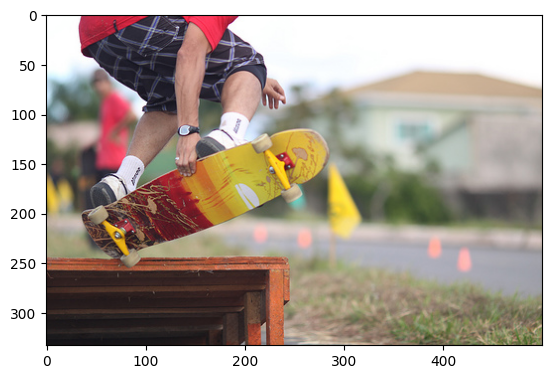

In [ ]:
#Below we are testing model on 5 different images

rid = np.random.randint(0, len(X_train))
plt.imshow(Image.open(image_path + X_train[rid]))

Real Caption: <start> a skateboarder ollies off a ramp <end>
Prediction Caption: a man in like match with outstretched arms crossed arms a person flying <end>


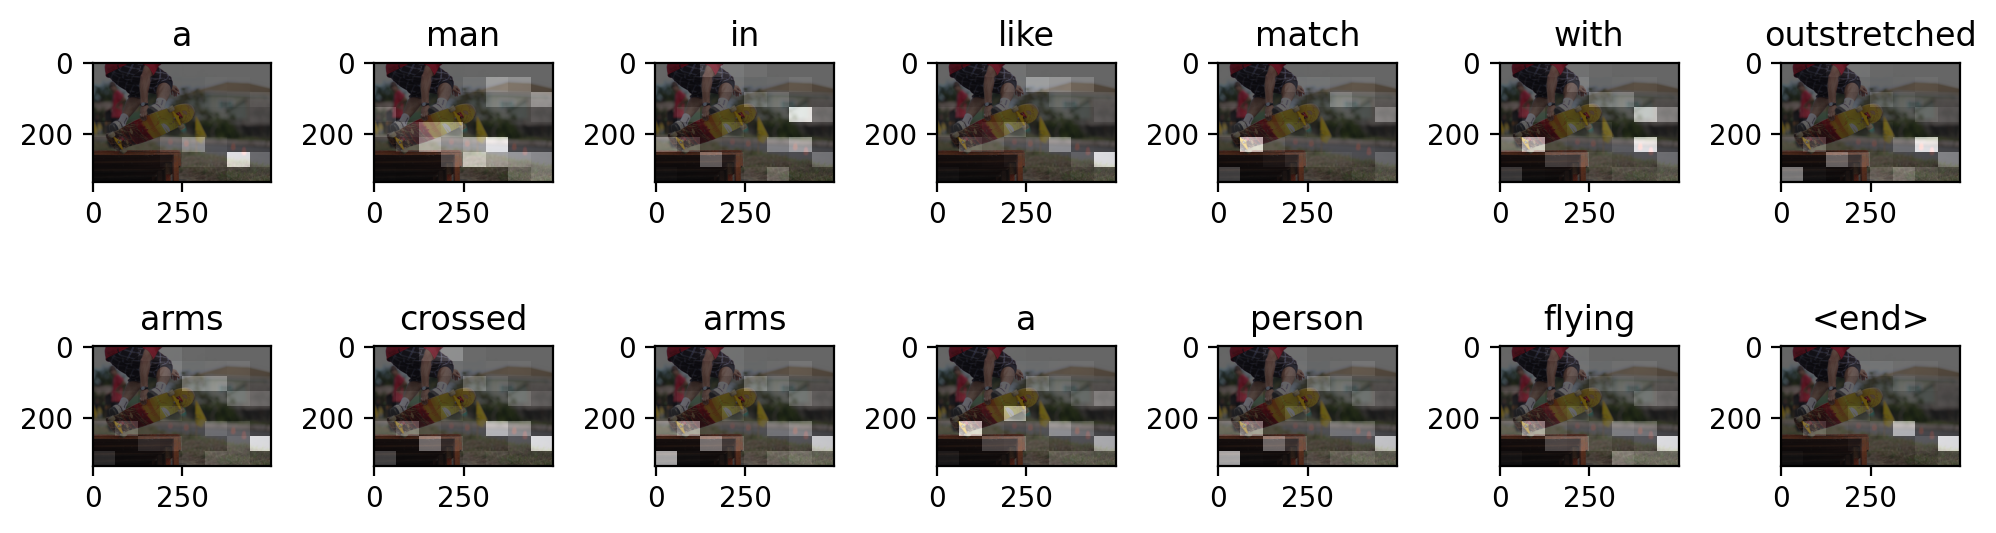

In [ ]:
image = X_train[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_train[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20 and len(result)>5):
    bl =False

  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
!git clone https://github.com/vinayaksharmagh/IMcap.git

Cloning into 'IMcap'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 188 (delta 9), reused 24 (delta 9), pack-reused 153
Receiving objects: 100% (188/188), 317.95 MiB | 14.29 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Updating files: 100% (61/61), done.


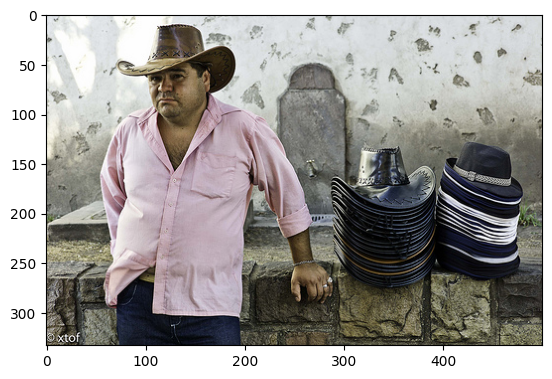

In [ ]:
rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> a man in a pink shirt stands next to a stack of hats <end>
Prediction Caption: a man wearing a woman <end>


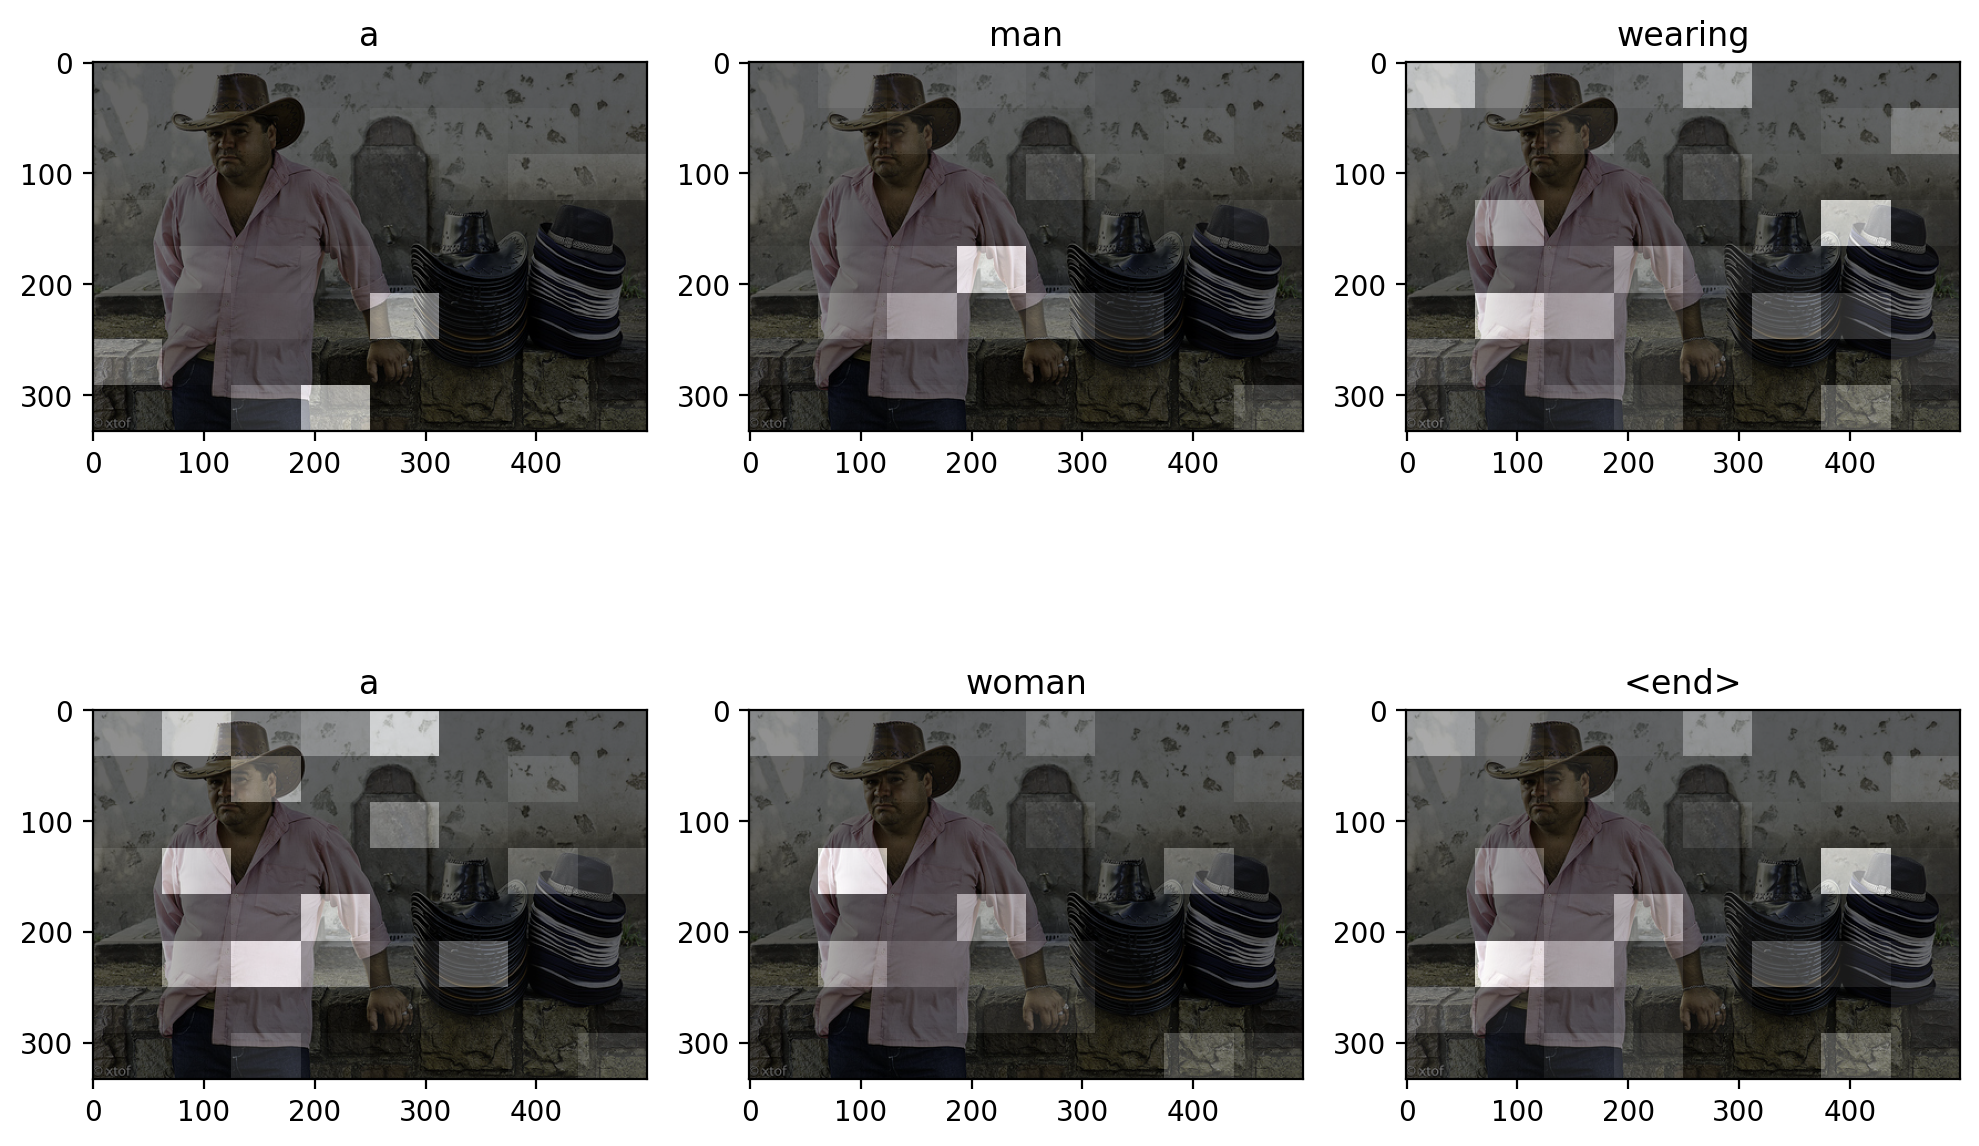

In [ ]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

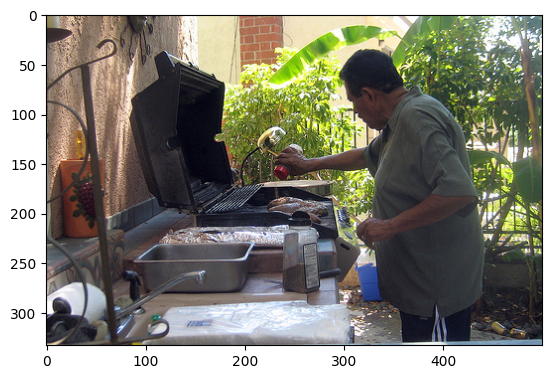

In [ ]:
rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> a man is seasoning food on a grill <end>
Prediction Caption: a dad playing with gloves with gloves on a metal worker taking care is working <end>


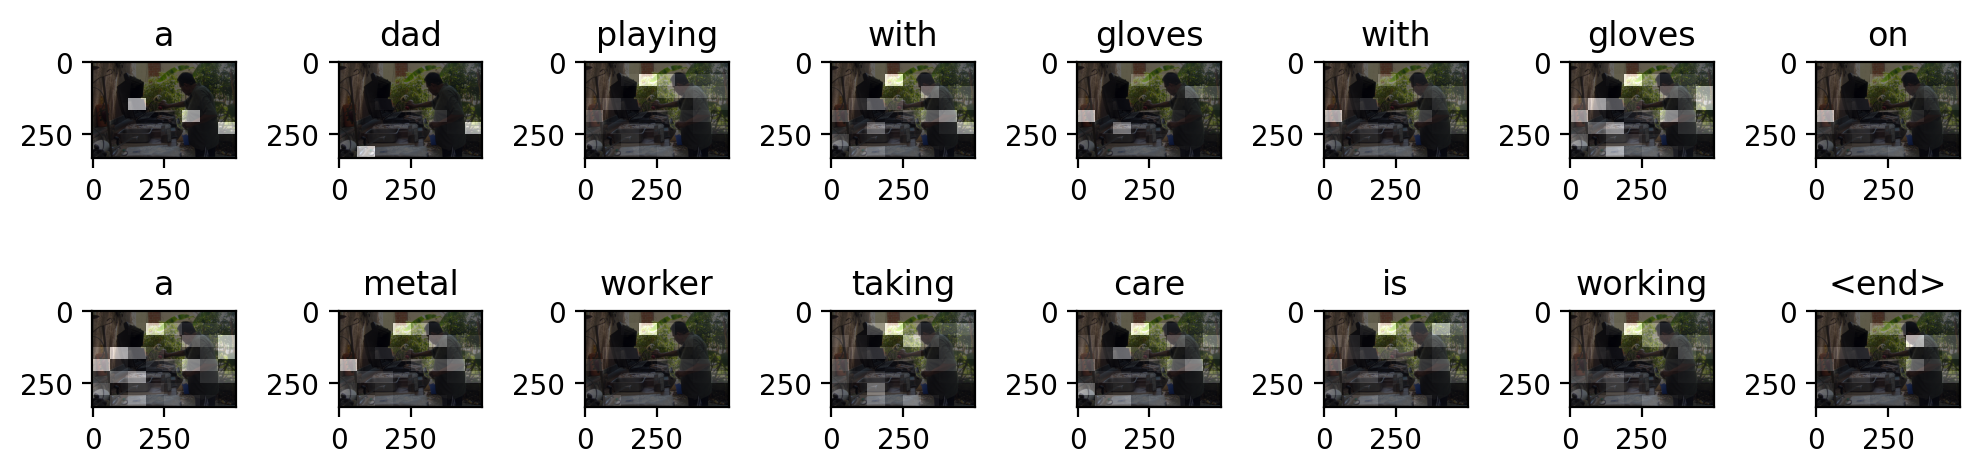

In [ ]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

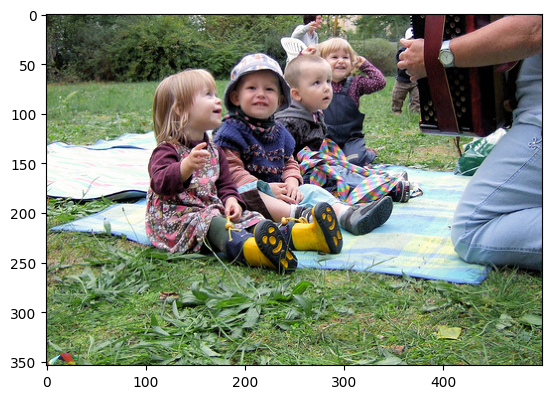

In [ ]:
rid = np.random.randint(0, len(X_test))
plt.imshow(Image.open(image_path + X_test[rid]))

Real Caption: <start> the brown dog is running parallel to the waves in the water <end>
Prediction Caption: a dog walks along splashing a tan and two dogs in the ocean <end>


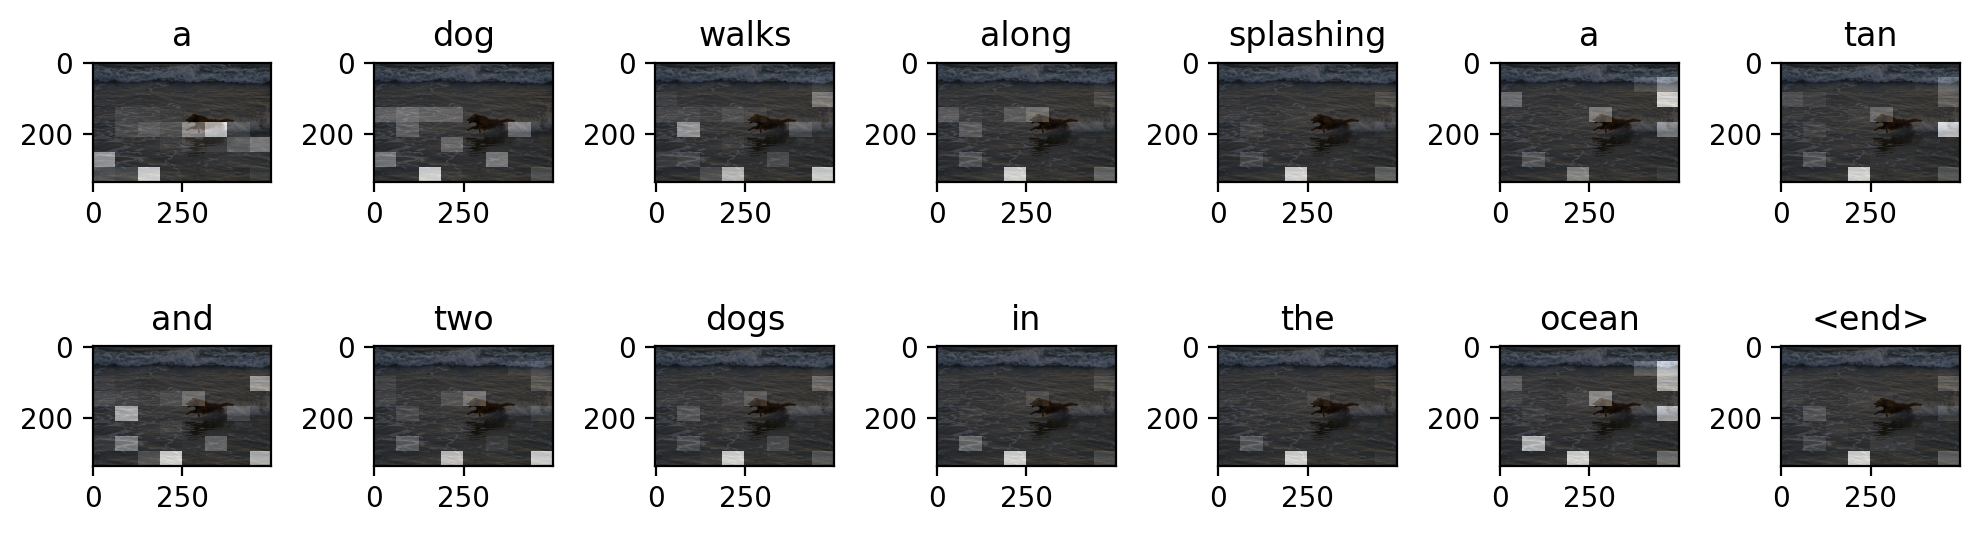

In [ ]:
image = X_test[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

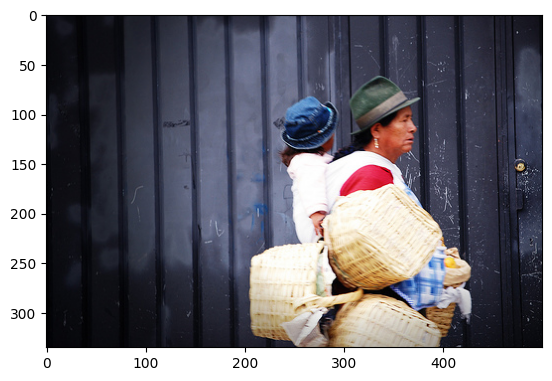

In [ ]:
rid = np.random.randint(0, len(X_train))
plt.imshow(Image.open(image_path + X_train[rid]))

Real Caption: <start> a south american looking indian woman loaded down with baskets and a young child <end>
Prediction Caption: a woman with stuffed animal an adult woman wearing a young girl climbing and observing a woman <end>


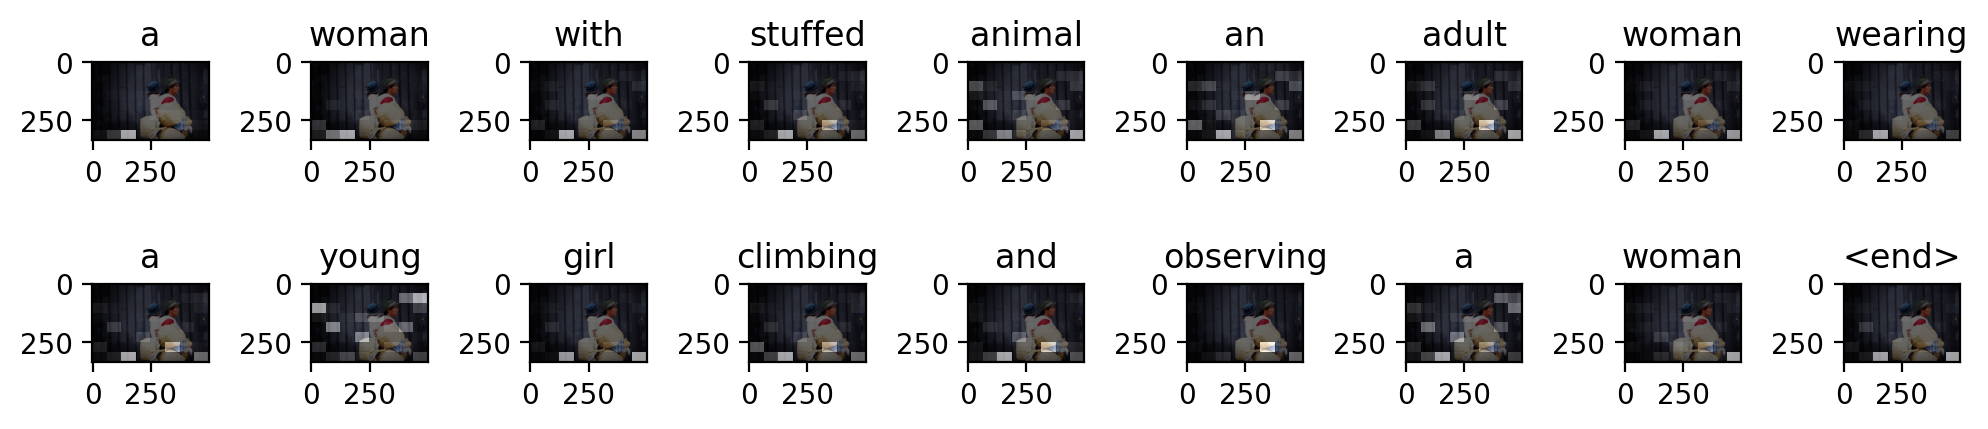

In [ ]:
image = X_train[rid]
real_caption = ' '.join([ind_word_map[i] for i in y_train[rid] if i not in [0]])
result, attention_plot = evaluate(image)

bl = True
while(bl): #sanity check (avoiding predictions having > 20 words)
  if(len(result)<=20):
    bl =False
  else:
    result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Bleu-1 scores

0.2890064862060426 - Xception - Original LSTM

0.2621547947179256 - Xception - Changed LSTM

0.28369470634644833 - InceptionV3 - Original LSTM


Paper :
https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00571-w

https://arxiv.org/pdf/1502.03044

https://github.com/vinayaksharmagh/IMcap/tree/master

https://github.com/AaronCCWong/Show-Attend-and-Tell/tree/master?tab=readme-ov-file

https://colab.research.google.com/drive/1L65WBAqzTFwX22OCEW4C8fYRkbEv9n1s?authuser=0#scrollTo=mLrKQbRPSN82

https://drive.google.com/drive/folders/1nqEDl1WHxc_02RvnhYl5kcyU8Y3SLWW9?usp=drive_link